In [17]:
import csv # Импорт библиотеки для работы с CSV файлами (чтение и запись данных в формате таблиц)
import random # Импорт библиотеки для генерации случайных чисел и перемешивания данных
import matplotlib.pyplot as plt # Импорт библиотеки для построения графиков и визуализации результатов

In [18]:
# 1. Функция для загрузки данных из CSV файла и преобразования в числовой формат
def load_data(filename):
    # Открываем файл в режиме чтения
    with open(filename, 'r') as f:
        # Создаем объект для чтения CSV как словаря (по именам колонок)
        reader = csv.DictReader(f)
        # Создаем пустой список для хранения всех данных
        data = []
        # Проходим по каждой строке в CSV файле
        for row in reader:
            # Преобразуем пол в числовой формат: female=1, male=0
            gender = 1 if row['gender'] == 'female' else 0
            
            # Преобразуем расовую/этническую группу в число
            # Разделяем строку по пробелам и берем последнюю часть (A, B, C, D, E)
            race_group = row['race/ethnicity'].split()[-1]
            # Создаем словарь для преобразования буквенных обозначений в числа
            race = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}[race_group]
            
            # Преобразуем уровень образования родителей в числовую шкалу
            parental_edu = {
                'some high school': 0,      # некоторое школьное образование = 0
                'high school': 1,           # средняя школа = 1
                'some college': 2,          # некоторое колледж = 2
                "associate's degree": 3,    # степень ассоциата = 3
                "bachelor's degree": 4,     # степень бакалавра = 4
                "master's degree": 5        # степень магистра = 5
            }[row['parental level of education']]  # берем значение из соответствующей колонки
            
            # Преобразуем тип обеда: стандартный=1, бесплатный/льготный=0
            lunch = 1 if row['lunch'] == 'standard' else 0
            
            # Преобразуем статус подготовительных курсов: пройдены=1, не пройдены=0
            prep = 1 if row['test preparation course'] == 'completed' else 0
            
            # Преобразуем баллы экзаменов из строк в целые числа
            math = int(row['math score'])        # балл по математике
            reading = int(row['reading score'])  # балл по чтению
            writing = int(row['writing score'])  # балл по письму
            
            # Добавляем преобразованную строку данных в общий список
            data.append([gender, race, parental_edu, lunch, prep, math, reading, writing])
    # Возвращаем полный набор числовых данных
    return data

In [19]:
# 2. Функция для разделения данных на обучающую и тестовую выборки
def split_data(data, train_ratio=0.7):
    # Перемешиваем данные случайным образом для устранения порядка
    random.shuffle(data)
    # Вычисляем индекс для разделения данных (70% для обучения)
    split_idx = int(len(data) * train_ratio)
    # Возвращаем обучающую выборку (первые split_idx элементов) и тестовую (остальные)
    return data[:split_idx], data[split_idx:]

In [20]:
# 3. Класс для реализации линейной регрессии с нуля
class LinearRegression:
    # Конструктор класса - инициализация модели
    def __init__(self):
        # Коэффициенты модели (пока не определены)
        self.coef_ = None
    
    # Метод для обучения модели на данных X и y
    def fit(self, X, y):
        # Добавляем столбец единиц к каждой строке X для учета свободного члена (intercept)
        X = [[1] + row for row in X]
        # Транспонируем матрицу X (меняем строки и столбцы местами)
        XT = list(zip(*X))
        # Вычисляем матрицу X^T * X (произведение транспонированной матрицы на исходную)
        XTX = [[sum(a*b for a,b in zip(row1, row2)) for row2 in XT] for row1 in XT]
        # Вычисляем вектор X^T * y (произведение транспонированной матрицы на вектор целевых значений)
        XTy = [sum(a*b for a,b in zip(row, y)) for row in XT]
        
        # Решение системы линейных уравнений методом Гаусса (исключения)
        # Получаем размерность системы (количество уравнений и неизвестных)
        n = len(XTX)
        # Проходим по каждой строке матрицы для приведения к диагональному виду
        for i in range(n):
            # Нормализация текущей строки: делим на диагональный элемент
            factor = XTX[i][i]  # Диагональный элемент текущей строки
            # Делим все элементы текущей строки на диагональный элемент
            for j in range(n):
                XTX[i][j] /= factor
            # Делим соответствующий элемент правой части на тот же коэффициент
            XTy[i] /= factor
            
            # Исключение в других строках: обнуляем элементы в i-м столбце других строк
            for k in range(n):
                # Пропускаем текущую строку (не исключаем сами себя)
                if k != i:
                    # Коэффициент для исключения (элемент в k-й строке, i-м столбце)
                    factor2 = XTX[k][i]
                    # Вычитаем из k-й строки текущую строку, умноженную на factor2
                    for j in range(n):
                        XTX[k][j] -= factor2 * XTX[i][j]
                    # Вычитаем из правой части соответствующий элемент
                    XTy[k] -= factor2 * XTy[i]
        # Сохраняем найденные коэффициенты регрессии
        self.coef_ = XTy
    
    # Метод для предсказания значений на новых данных X
    def predict(self, X):
        # Добавляем столбец единиц для intercept к каждой строке X
        X = [[1] + row for row in X]
        # Вычисляем предсказания: y_pred = X * coef (скалярное произведение каждой строки на коэффициенты)
        return [sum(a*b for a,b in zip(row, self.coef_)) for row in X]
    
    # Метод для вычисления коэффициента детерминации R²
    def score(self, X, y):
        # Получаем предсказанные значения для X
        y_pred = self.predict(X)
        # Вычисляем среднее значение фактических y
        y_mean = sum(y) / len(y)
        # Вычисляем общую сумму квадратов (total sum of squares) - общая вариативность данных
        ss_tot = sum((yi - y_mean) ** 2 for yi in y)
        # Вычисляем остаточную сумму квадратов (residual sum of squares) - необъясненная вариативность
        ss_res = sum((yi - y_pred_i) ** 2 for yi, y_pred_i in zip(y, y_pred))
        # Вычисляем R² = 1 - (SS_res / SS_tot), проверяем деление на ноль
        return 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

In [21]:
# Загружаем и преобразуем данные из CSV файла в числовой формат
data = load_data('exams - exams.csv')

# Разделяем данные на обучающую (70%) и тестовую (30%) выборки
train_data, test_data = split_data(data)

# Выводим информацию о размерах выборок для контроля
print(f"Всего записей в датасете: {len(data)}")
print(f"Записей в обучающей выборке: {len(train_data)}")
print(f"Записей в тестовой выборке: {len(test_data)}")

# Создаем базовые признаки (одинаковые для всех моделей) - первые 5 столбцов
X_train_basic = [row[:5] for row in train_data]  # gender, race, parental_edu, lunch, prep
X_test_basic = [row[:5] for row in test_data]    # тестовые базовые признаки

# Создаем целевые переменные для всех трех экзаменов
y_math_train = [row[5] for row in train_data]    # баллы по математике (обучающие)
y_math_test = [row[5] for row in test_data]      # баллы по математике (тестовые)
y_reading_train = [row[6] for row in train_data] # баллы по чтению (обучающие)
y_reading_test = [row[6] for row in test_data]   # баллы по чтению (тестовые)
y_writing_train = [row[7] for row in train_data] # баллы по письму (обучающие)
y_writing_test = [row[7] for row in test_data]   # баллы по письму (тестовые)

# Выводим разделитель для лучшей читаемости вывода
print("\n" + "="*50)
print("МОДЕЛЬ 1: БЕЗ учета других экзаменов")
print("="*50)

# Создаем и обучаем модель для математики (только базовые признаки)
model_math1 = LinearRegression()          # Создаем объект модели
model_math1.fit(X_train_basic, y_math_train)  # Обучаем модель на обучающих данных
r2_math1 = model_math1.score(X_test_basic, y_math_test)  # Вычисляем R² на тестовых данных
print(f"Математика R²: {r2_math1:.3f}")  # Выводим результат

# Создаем и обучаем модель для чтения (только базовые признаки)
model_reading1 = LinearRegression()       # Создаем объект модели
model_reading1.fit(X_train_basic, y_reading_train)  # Обучаем модель
r2_reading1 = model_reading1.score(X_test_basic, y_reading_test)  # Вычисляем R²
print(f"Чтение R²: {r2_reading1:.3f}")   # Выводим результат

# Создаем и обучаем модель для письма (только базовые признаки)
model_writing1 = LinearRegression()       # Создаем объект модели
model_writing1.fit(X_train_basic, y_writing_train)  # Обучаем модель
r2_writing1 = model_writing1.score(X_test_basic, y_writing_test)  # Вычисляем R²
print(f"Письмо R²: {r2_writing1:.3f}")   # Выводим результат

# Выводим разделитель для второй модели
print("\n" + "="*50)
print("МОДЕЛЬ 2: С учетом уже прошедших экзаменов")
print("="*50)

# Модель для математики (только базовые признаки - первый экзамен, нет предыдущих)
model_math2 = LinearRegression()          # Создаем объект модели
model_math2.fit(X_train_basic, y_math_train)  # Обучаем на базовых признаках
r2_math2 = model_math2.score(X_test_basic, y_math_test)  # Вычисляем R²
print(f"Математика R²: {r2_math2:.3f} (первый экзамен)")  # Выводим с пояснением

# Модель для чтения (базовые признаки + результаты математики)
# Создаем расширенные признаки: базовые + баллы по математике
X_reading_train = [X_train_basic[i] + [y_math_train[i]] for i in range(len(X_train_basic))]
X_reading_test = [X_test_basic[i] + [y_math_test[i]] for i in range(len(X_test_basic))]
model_reading2 = LinearRegression()       # Создаем объект модели
model_reading2.fit(X_reading_train, y_reading_train)  # Обучаем на расширенных признаках
r2_reading2 = model_reading2.score(X_reading_test, y_reading_test)  # Вычисляем R²
print(f"Чтение R²: {r2_reading2:.3f} (после математики)")  # Выводим с пояснением

# Модель для письма (базовые признаки + результаты математики + результаты чтения)
# Создаем расширенные признаки: базовые + баллы по математике + баллы по чтению
X_writing_train = [X_train_basic[i] + [y_math_train[i], y_reading_train[i]] for i in range(len(X_train_basic))]
X_writing_test = [X_test_basic[i] + [y_math_test[i], y_reading_test[i]] for i in range(len(X_test_basic))]
model_writing2 = LinearRegression()       # Создаем объект модели
model_writing2.fit(X_writing_train, y_writing_train)  # Обучаем на расширенных признаках
r2_writing2 = model_writing2.score(X_writing_test, y_writing_test)  # Вычисляем R²
print(f"Письмо R²: {r2_writing2:.3f} (после математики и чтения)")  # Выводим с пояснением

Всего записей в датасете: 1000
Записей в обучающей выборке: 700
Записей в тестовой выборке: 300

МОДЕЛЬ 1: БЕЗ учета других экзаменов
Математика R²: 0.157
Чтение R²: 0.116
Письмо R²: 0.209

МОДЕЛЬ 2: С учетом уже прошедших экзаменов
Математика R²: 0.157 (первый экзамен)
Чтение R²: 0.790 (после математики)
Письмо R²: 0.935 (после математики и чтения)


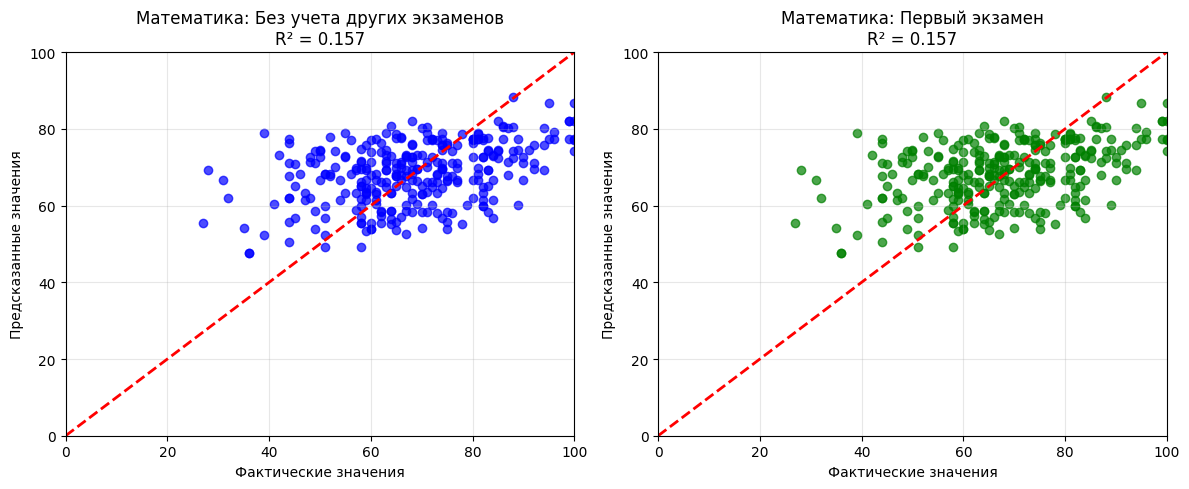

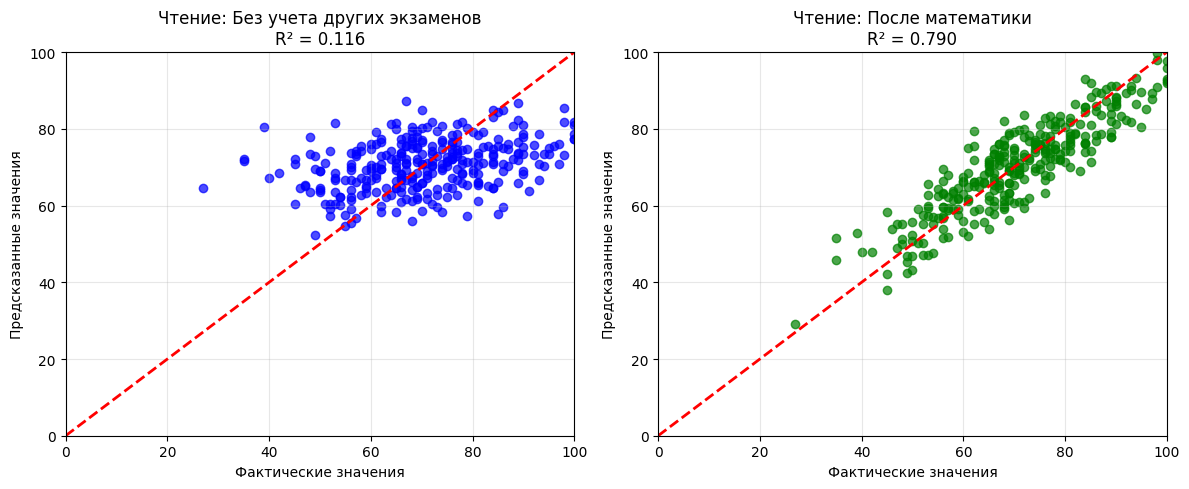

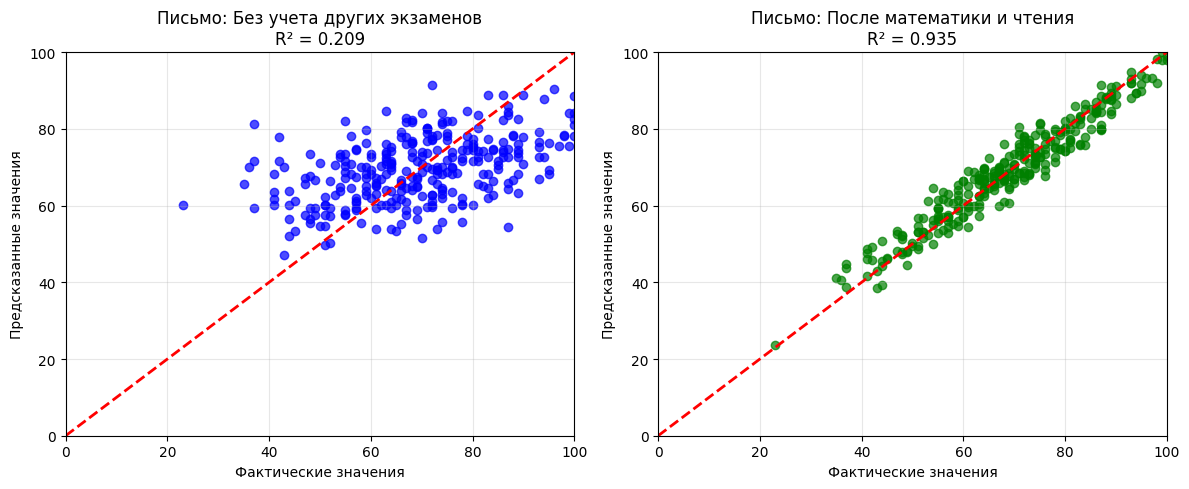


ВЫВОДЫ
1. МАТЕМАТИКА (первый экзамен):
   Без учета других экзаменов: R² = 0.157
   С учетом других экзаменов: R² = 0.157 (нет предыдущих экзаменов)

2. ЧТЕНИЕ (второй экзамен):
   Без учета других экзаменов: R² = 0.116
   С учетом математики: R² = 0.790
   Улучшение качества прогноза: +0.674

3. ПИСЬМО (третий экзамен):
   Без учета других экзаменов: R² = 0.209
   С учетом математики и чтения: R² = 0.935
   Улучшение качества прогноза: +0.726

4. ОБЩИЙ ВЫВОД:
   - Качество прогноза улучшается с каждым последующим экзаменом
   - Результаты предыдущих экзаменов значительно влияют на прогноз следующих
   - Наибольшее улучшение наблюдается у письма (последнего экзамена)
   - Последовательная зависимость экзаменов подтверждается экспериментально
   - Для точного прогнозирования важно учитывать результаты уже прошедших экзаменов


In [22]:
# Графики для математики
plt.figure(figsize=(12, 5))  # Создаем фигуру размером 12x5 дюймов

# Первый подграфик: математика без учета других экзаменов
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1-й график
y_pred_math1 = model_math1.predict(X_test_basic)  # Получаем предсказания для тестовых данных
plt.scatter(y_math_test, y_pred_math1, alpha=0.7, color='blue')  # Точечный график: факт vs предск
plt.plot([0, 100], [0, 100], 'r--', linewidth=2)  # Линия идеального предсказания (y=x)
plt.xlabel('Фактические значения')  # Подпись оси X
plt.ylabel('Предсказанные значения')  # Подпись оси Y
plt.title('Математика: Без учета других экзаменов\nR² = {:.3f}'.format(r2_math1))  # Заголовок
plt.grid(True, alpha=0.3)  # Включаем сетку с прозрачностью
plt.xlim(0, 100)  # Устанавливаем пределы оси X
plt.ylim(0, 100)  # Устанавливаем пределы оси Y

# Второй подграфик: математика (первый экзамен)
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2-й график
y_pred_math2 = model_math2.predict(X_test_basic)  # Получаем предсказания
plt.scatter(y_math_test, y_pred_math2, alpha=0.7, color='green')  # Точечный график
plt.plot([0, 100], [0, 100], 'r--', linewidth=2)  # Линия идеального предсказания
plt.xlabel('Фактические значения')  # Подпись оси X
plt.ylabel('Предсказанные значения')  # Подпись оси Y
plt.title('Математика: Первый экзамен\nR² = {:.3f}'.format(r2_math2))  # Заголовок
plt.grid(True, alpha=0.3)  # Включаем сетку
plt.xlim(0, 100)  # Устанавливаем пределы оси X
plt.ylim(0, 100)  # Устанавливаем пределы оси Y
plt.tight_layout()  # Автоматически настраиваем расположение графиков
plt.show()  # Показываем графики

# Графики для чтения
plt.figure(figsize=(12, 5))  # Создаем новую фигуру

# Первый подграфик: чтение без учета других экзаменов
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1-й график
y_pred_reading1 = model_reading1.predict(X_test_basic)  # Получаем предсказания
plt.scatter(y_reading_test, y_pred_reading1, alpha=0.7, color='blue')  # Точечный график
plt.plot([0, 100], [0, 100], 'r--', linewidth=2)  # Линия идеального предсказания
plt.xlabel('Фактические значения')  # Подпись оси X
plt.ylabel('Предсказанные значения')  # Подпись оси Y
plt.title('Чтение: Без учета других экзаменов\nR² = {:.3f}'.format(r2_reading1))  # Заголовок
plt.grid(True, alpha=0.3)  # Включаем сетку
plt.xlim(0, 100)  # Устанавливаем пределы оси X
plt.ylim(0, 100)  # Устанавливаем пределы оси Y

# Второй подграфик: чтение после математики
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2-й график
y_pred_reading2 = model_reading2.predict(X_reading_test)  # Получаем предсказания
plt.scatter(y_reading_test, y_pred_reading2, alpha=0.7, color='green')  # Точечный график
plt.plot([0, 100], [0, 100], 'r--', linewidth=2)  # Линия идеального предсказания
plt.xlabel('Фактические значения')  # Подпись оси X
plt.ylabel('Предсказанные значения')  # Подпись оси Y
plt.title('Чтение: После математики\nR² = {:.3f}'.format(r2_reading2))  # Заголовок
plt.grid(True, alpha=0.3)  # Включаем сетку
plt.xlim(0, 100)  # Устанавливаем пределы оси X
plt.ylim(0, 100)  # Устанавливаем пределы оси Y
plt.tight_layout()  # Автоматически настраиваем расположение
plt.show()  # Показываем графики

# Графики для письма
plt.figure(figsize=(12, 5))  # Создаем новую фигуру

# Первый подграфик: письмо без учета других экзаменов
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1-й график
y_pred_writing1 = model_writing1.predict(X_test_basic)  # Получаем предсказания
plt.scatter(y_writing_test, y_pred_writing1, alpha=0.7, color='blue')  # Точечный график
plt.plot([0, 100], [0, 100], 'r--', linewidth=2)  # Линия идеального предсказания
plt.xlabel('Фактические значения')  # Подпись оси X
plt.ylabel('Предсказанные значения')  # Подпись оси Y
plt.title('Письмо: Без учета других экзаменов\nR² = {:.3f}'.format(r2_writing1))  # Заголовок
plt.grid(True, alpha=0.3)  # Включаем сетку
plt.xlim(0, 100)  # Устанавливаем пределы оси X
plt.ylim(0, 100)  # Устанавливаем пределы оси Y

# Второй подграфик: письмо после математики и чтения
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2-й график
y_pred_writing2 = model_writing2.predict(X_writing_test)  # Получаем предсказания
plt.scatter(y_writing_test, y_pred_writing2, alpha=0.7, color='green')  # Точечный график
plt.plot([0, 100], [0, 100], 'r--', linewidth=2)  # Линия идеального предсказания
plt.xlabel('Фактические значения')  # Подпись оси X
plt.ylabel('Предсказанные значения')  # Подпись оси Y
plt.title('Письмо: После математики и чтения\nR² = {:.3f}'.format(r2_writing2))  # Заголовок
plt.grid(True, alpha=0.3)  # Включаем сетку
plt.xlim(0, 100)  # Устанавливаем пределы оси X
plt.ylim(0, 100)  # Устанавливаем пределы оси Y
plt.tight_layout()  # Автоматически настраиваем расположение
plt.show()  # Показываем графики

print("\n" + "="*50)
print("ВЫВОДЫ")
print("="*50)

# Выводы по математике
print("1. МАТЕМАТИКА (первый экзамен):")
print(f"   Без учета других экзаменов: R² = {r2_math1:.3f}")
print(f"   С учетом других экзаменов: R² = {r2_math2:.3f} (нет предыдущих экзаменов)")

# Выводы по чтению
print("\n2. ЧТЕНИЕ (второй экзамен):")
print(f"   Без учета других экзаменов: R² = {r2_reading1:.3f}")
print(f"   С учетом математики: R² = {r2_reading2:.3f}")
print(f"   Улучшение качества прогноза: +{r2_reading2 - r2_reading1:.3f}")

# Выводы по письму
print("\n3. ПИСЬМО (третий экзамен):")
print(f"   Без учета других экзаменов: R² = {r2_writing1:.3f}")
print(f"   С учетом математики и чтения: R² = {r2_writing2:.3f}")
print(f"   Улучшение качества прогноза: +{r2_writing2 - r2_writing1:.3f}")

# Общие выводы
print("\n4. ОБЩИЙ ВЫВОД:")
print("   - Качество прогноза улучшается с каждым последующим экзаменом")
print("   - Результаты предыдущих экзаменов значительно влияют на прогноз следующих")
print("   - Наибольшее улучшение наблюдается у письма (последнего экзамена)")
print("   - Последовательная зависимость экзаменов подтверждается экспериментально")
print("   - Для точного прогнозирования важно учитывать результаты уже прошедших экзаменов")